# Updating Regional Timeseries for OISST Data


# Objective 1: Updating Regional Timeseries

New objectives on the "Update Timeseries" notebooks. 

Should the whole process be done: load all sst - > mask -> get timeseries -> subtract masked climatology?

Or just get the timeseries, and use the python marine heatwave function that matches heatwaveR?

Can we make everything generic, to take any list of names with paths to shapes?


In [1]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import regionmask
import oisstools as ot
from datetime import date

# Set the workspace - local/ docker
box_root = ot.set_workspace("local")

# variable name to mask and make timeline from
var_name = "sst"

print(f"Working via directory: {box_root}")

Working via directory: /Users/akemberling/Box/


## Set the Update Period

In [2]:
# start and end years for the update
start_yr = 2021
end_yr   = 2021

print(f"Updating {start_yr} - {end_yr}")

Updating 2016 - 2021


## Select the Group of Regions to Update:

In [3]:
# Choose a set of regions to update (gmri_sst_focal_areas, lme, nmfs_trawl_regions)

# Option 1.
# update_regions = "gmri_sst_focal_areas"

# Option 2.
update_regions = "lme"

# Option 3.
# update_regions = "nmfs_trawl_regions"

# Option 4.
# update_regions = "nelme_regions"

print(f"Updating Timeseries for {update_regions}")

Updating Timeseries for lme


### Get all their names using lookup catalog

In [4]:
# Get their names from lookup catalog
region_names = ot.get_region_names(region_group = update_regions)
print("Updating Timeseries for:")
for region in region_names:
    print(f" - {region}")

Updating Timeseries for:
 - agulhas_current
 - aleutian_islands
 - antarctica
 - arabian_sea
 - baltic_sea
 - barents_sea
 - bay_of_bengal
 - beaufort_sea
 - benguela_current
 - black_sea
 - california_current
 - canadian_eastern_arctic_west_greenland
 - canadian_high_arctic_north_greenland
 - canary_current
 - caribbean_sea
 - celtic_biscay_shelf
 - central_arctic
 - east_bering_sea
 - east_brazil_shelf
 - east_central_australian_shelf
 - east_china_sea
 - east_siberian_sea
 - faroe_plateau
 - greenland_sea
 - guinea_current
 - gulf_of_alaska
 - gulf_of_california
 - gulf_of_mexico
 - gulf_of_thailand
 - hudson_bay_complex
 - humboldt_current
 - iberian_coastal
 - iceland_shelf_and_sea
 - indonesian_sea
 - insular_pacific_hawaiian
 - kara_sea
 - kuroshio_current
 - labrador_newfoundland
 - laptev_sea
 - mediterranean_sea
 - new_zealand_shelf
 - north_australian_shelf
 - north_brazil_shelf
 - north_sea
 - northeast_australian_shelf
 - northeast_us_continental_shelf
 - northern_bering_c

### Get shapefile details using lookup function

In [6]:
# Get paths to each shapefile
mask_paths = ot.get_timeseries_paths(box_root = box_root, 
                                     region_list = region_names, 
                                     region_group = update_regions, 
                                     polygons = True)

# Use paths to make list of loaded polygons
mask_list = []
for mask_path_i in mask_paths:
    mask_shape = gpd.read_file(mask_path_i)
    mask_list.append(mask_shape)
    print(f"Loading Mask Area :  {mask_path_i}")

Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/large_marine_ecosystems/agulhas_current_exterior.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/large_marine_ecosystems/aleutian_islands_exterior.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/large_marine_ecosystems/antarctica_exterior.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/large_marine_ecosystems/arabian_sea_exterior.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/large_marine_ecosystems/baltic_sea_exterior.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/large_marine_ecosystems/barents_sea_exterior.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/large_marine_ecosystems/bay_of_bengal_exterior.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/Shapefiles/large_marine_ecosystems/beaufort_sea_exterior.geojson
Loading Mask Area :  /Users/akemberling/Box/RES_Data/S

## Load the desired update years of OISSTv2 data
 
Use the load_box_oisst function to get the temperature data off of box for the period within the the start and end years of the update.

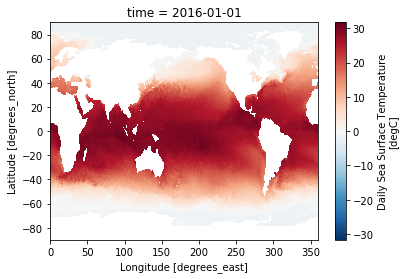

In [7]:
# Load OISSt using ot.load_box_oisst()
oisst_grid = ot.load_box_oisst(box_root, 
                               start_yr, 
                               end_yr, 
                               anomalies = False, 
                               do_parallel = True)
oisst_grid.sst.isel(time = 0).plot()

## Calculate Temp-timeseries for Update-period

In [8]:
# list to store the update period timeseries
new_ts = []

for mask_shp, mask_name in zip(mask_list, region_names):
    print(f"Processing {mask_name}")
    
    # Get masked timeseries
    masked_ts = ot.calc_ts_mask(grid_obj = oisst_grid, 
                                shp_obj = mask_shp, 
                                shp_name = mask_name,
                                var_name = var_name)
    
    # Add to list
    new_ts.append(masked_ts)

Processing agulhas_current
Processing aleutian_islands
Processing antarctica
Processing arabian_sea
Processing baltic_sea
Processing barents_sea
Processing bay_of_bengal
Processing beaufort_sea
Processing benguela_current
Processing black_sea
Processing california_current
Processing canadian_eastern_arctic_west_greenland
Processing canadian_high_arctic_north_greenland
Processing canary_current
Processing caribbean_sea
Processing celtic_biscay_shelf
Processing central_arctic
Processing east_bering_sea
Processing east_brazil_shelf
Processing east_central_australian_shelf
Processing east_china_sea
Processing east_siberian_sea
Processing faroe_plateau
Processing greenland_sea
Processing guinea_current
Processing gulf_of_alaska
Processing gulf_of_california
Processing gulf_of_mexico
Processing gulf_of_thailand
Processing hudson_bay_complex
Processing humboldt_current
Processing iberian_coastal
Processing iceland_shelf_and_sea
Processing indonesian_sea
Processing insular_pacific_hawaiian
Pro

# Load existing LME timeseries to Update

Switching to the likelihood timeseries because they contain the climatology information.


### Get timeseries details using lookup function

In [10]:
# Get paths to each existing timeseries
mask_ts_paths = ot.get_timeseries_paths(box_root = box_root, 
                                        region_list = region_names, 
                                        region_group = update_regions, 
                                        polygons = False)


# Open existing time series to update them
ts_list = []
for mask_ts_path in mask_ts_paths:
    mask_ts = pd.read_csv(mask_ts_path)
    ts_list.append(mask_ts)
    print(f"Loading Timeseries : {mask_ts_path}")
    

Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_agulhas_current.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_aleutian_islands.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_antarctica.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_arabian_sea.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_baltic_sea.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_barents_sea.csv
Loading Timeseries : /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_mari

# Append Updates to Existing Timeseries

Now that the update period has been processed we can append it onto what we already have to get a complete time series for SST.

In [11]:
# Step 4. match updates to existing timelines
complete_ts = []
for update_ts, old_ts in zip(new_ts, ts_list):
    # Append without overlap
    appended_ts = ot.append_sst_ts(old_ts = old_ts, update_ts = update_ts)
    complete_ts.append(appended_ts)

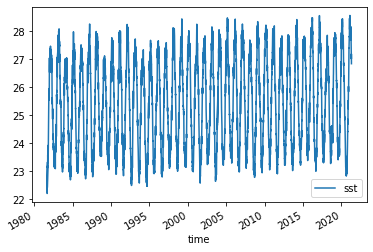

In [12]:
# Plot the first on to check
complete_ts[0].plot("time", "sst")

# Use Regional Climatology to Get Anomalies

We have tables with dates and temperature, and we have matching tables that contain the climate average for each day of year. Now we just need to pull that distinct information from the climatology, and join back using MOD.

In [13]:
# Step 4. match updates to existing timelines
anomaly_timeseries = []
for clim_ts, update_ts in zip(ts_list, complete_ts):
    # Append without overlap
    anomaly_ts = ot.rejoin_climatology(old_ts = clim_ts, new_ts = update_ts)
    anomaly_timeseries.append(anomaly_ts)

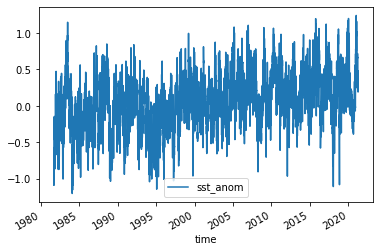

In [14]:
# See if Anomalies look fine
check_number = 0
anomaly_timeseries[check_number].plot("time", "sst_anom")

In [15]:
# See if Anomalies look fine
print(f"Timeseries Data for: {region_names[check_number]}")
anomaly_timeseries[check_number].tail()

Timeseries Data for: agulhas_current


,time,sst,modified_ordinal_day,sst_clim,clim_sd,sst_anom
14470,2021-04-14 12:00:00,27.007921,105,26.734870,2.422935,0.273051
14471,2021-04-15 12:00:00,27.182423,106,26.703766,2.440280,0.478657
14472,2021-04-16 12:00:00,27.061083,107,26.689493,2.464320,0.371590
14473,2021-04-17 12:00:00,26.879984,108,26.667164,2.459197,0.212820
14474,2021-04-18 12:00:00,26.835241,109,26.640570,2.455782,0.194671


# Saving Updates

Once the timeseries have been checked they just need to be saved out again.

In [16]:
# Use the file paths we looked up before to set the save destinations
for updated_timeline_i, update_path_i in zip(anomaly_timeseries, mask_ts_paths):
    # save them
    print(f"Saving: {update_path_i}")
    updated_timeline_i.to_csv(update_path_i, index = False)

Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_agulhas_current.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_aleutian_islands.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_antarctica.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_arabian_sea.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_baltic_sea.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_barents_sea.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_bay_of_bengal.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/

<hr>

#  Removed from Python Steps: Marine Heatwaves

The implementation of the marineHeatWave module's output was more of a burden than it was worth. Opted to output temperature and anomalies and ignore the rest.

In [ ]:
# 5. Then use heatwave module to get the anomalies from the old and new climatology

# Test timeseries
tester_ts = complete_ts[0]
time_vals = tester_ts[["time"]].values.astype("datetime64")
temp_vals = tester_ts[["sst"]].values

# my time
time_vals

# getting to datetime.date
time_vals_date = time_vals.astype('M8[D]').astype("O")

# use date.toordinal() to get each value as an integer
to_ord = lambda t: t.toordinal()
vfunc = np.vectorize(to_ord)
time_vals_ord = vfunc(time_vals_date)
time_vals_ord

# detect heatwaves
test_hw = mhw.detect(t = time_vals_ord, 
                     temp = temp_vals[:,0], 
                     climatologyPeriod = [1982,2011], 
                     pctile = 90, 
                     windowHalfWidth = 5, 
                     smoothPercentile = True, 
                     smoothPercentileWidth = 31, 
                     minDuration = 5, 
                     joinAcrossGaps = True, 
                     maxGap = 2, 
                     maxPadLength = False, 
                     coldSpells = False, 
                     alternateClimatology = False)
    
# make into ddataframe
hw_out = pd.DataFrame.from_dict(test_hw[0]) # marine heatwaves
clim_out = pd.DataFrame.from_dict(test_hw[1]) # climatology